In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

In [17]:

prices = pd.read_csv('eurusd_daily.csv', parse_dates=True)

# Rename the 'Price' column to 'Date' and 'Unnamed: 1' to 'Price'
prices.rename(columns={'Date': 'Date', 'Unnamed: 1': 'Price'}, inplace=True)

# Calculate the returns and create a new DataFrame
returns = prices['Price'].pct_change().dropna()

# Now, 'prices' DataFrame contains two columns: 'Date' and 'Price'
# 'returns' DataFrame contains the calculated returns


In [40]:
print(returns)


1      0.002294
2      0.001569
3      0.000539
4     -0.005326
5     -0.013507
         ...   
247    0.001814
248   -0.004419
249    0.001661
250   -0.005066
251   -0.001081
Name: Price, Length: 251, dtype: float64


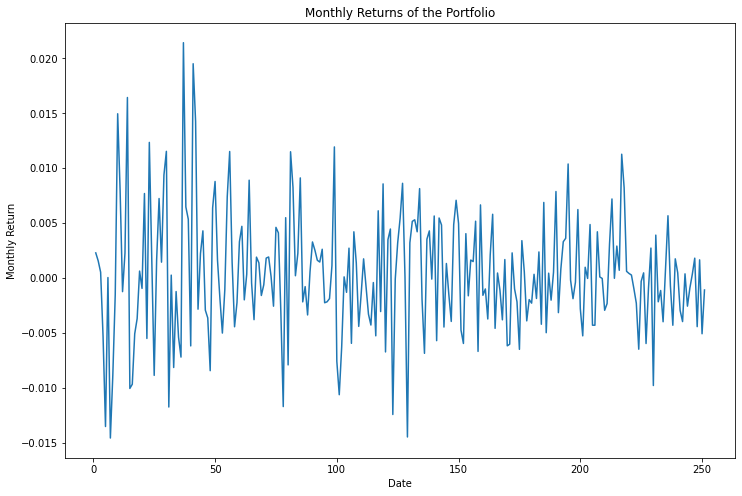

In [20]:
# Plot the monthly returns
plt.figure(figsize=(12, 8))
plt.plot(returns)
plt.xlabel('Date')
plt.ylabel('Monthly Return')
plt.title('Monthly Returns of the Portfolio')
plt.show()

Kurtosis: 1.1418579086560259
Skewness: 0.391388366848844
ADF Statistic: -12.006070034022502
p-value: 3.2617513583174177e-22
Critical Values: {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}


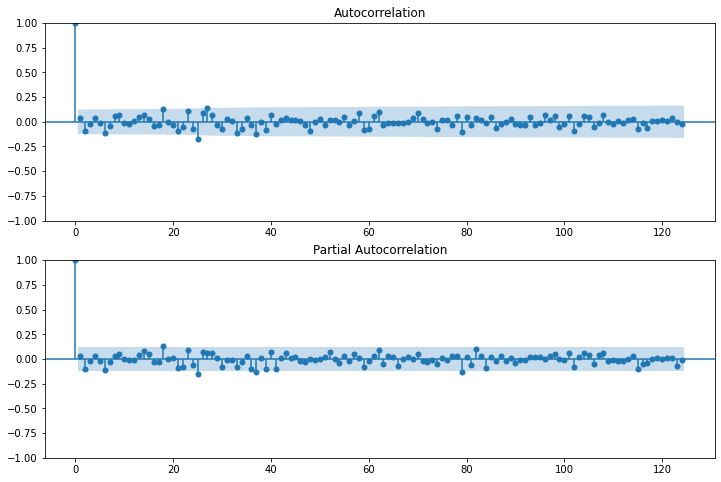

<Figure size 864x576 with 0 Axes>

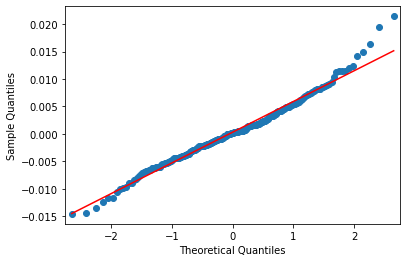

In [21]:
import statsmodels.api as sm
from scipy.stats import stats
# ACF and PACF plots
plt.figure(figsize=(12, 8))
ax1 = plt.subplot(211)
sm.graphics.tsa.plot_acf(returns, lags=124, ax=ax1)
ax2 = plt.subplot(212)
sm.graphics.tsa.plot_pacf(returns, lags=124, ax=ax2)

# QQ plot
plt.figure(figsize=(12, 8))
qq_plot = sm.qqplot(returns, line='s')

# Calculate Kurtosis and Skewness
kurt = stats.kurtosis(returns)
skew = stats.skew(returns)

print("Kurtosis:", kurt)
print("Skewness:", skew)

# Perform ADF test
adf_result = sm.tsa.adfuller(returns)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

plt.show()

In [22]:
# Specify GARCH model assumptions
basic_gm = arch_model(returns, p = 1, q = 1 , 
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 9.559541474184581e+18
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1601968685598236.0
Iteration:      3,   Func. Count:     29,   Neg. LLF: -959.7618648522582
Optimization terminated successfully    (Exit mode 0)
            Current function value: -959.7618677246232
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3


C:\Users\cdimopoulos\Anaconda3\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.113e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [23]:
print(gm_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                959.762
Distribution:                  Normal   AIC:                          -1911.52
Method:            Maximum Likelihood   BIC:                          -1897.42
                                        No. Observations:                  251
Date:                Tue, Aug 29 2023   Df Residuals:                      250
Time:                        11:03:05   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.8528e-04  2.494e-05      7.430  1.085e-13 [1.

In [24]:
gm_vol = gm_result.conditional_volatility
from sklearn.metrics import mean_absolute_error, mean_squared_error
gm_vol = gm_result.conditional_volatility
def evaluate(observation, forecast): 
    # Call sklearn function to calculate MAE
    mae = mean_absolute_error(observation, forecast)
    print(f'Mean Absolute Error (MAE): {round(mae,3)}')
    # Call sklearn function to calculate MSE
    mse = mean_squared_error(observation, forecast)
    print(f'Mean Squared Error (MSE): {round(mse,3)}')
    #rmse = mse**2(observation, forecast)
    return mae, mse#, rmse

# Backtest model with MAE, MSE
evaluate(returns.sub(returns.mean()).pow(2), gm_vol**2)

Mean Absolute Error (MAE): 0.0
Mean Squared Error (MSE): 0.0


(3.2687045360148e-05, 2.8058750079072448e-09)

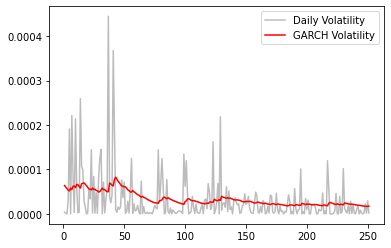

In [25]:
# Plot the actual rets volatility
plt.plot(returns.sub(returns.mean()).pow(2), 
         color = 'grey', alpha = 0.52, label = 'Daily Volatility')

# Plot EGARCH  estimated volatility
plt.plot(gm_vol**2, color = 'red', label = 'GARCH Volatility')

plt.legend(loc = 'upper right')
plt.show()

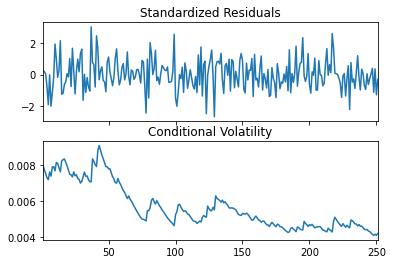

In [26]:
# Plot fitted results
gm_result.plot()
plt.show()

C:\Users\cdimopoulos\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


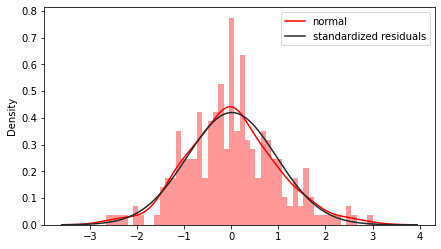

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# Obtain model estimated residuals and volatility
gm_resid = gm_result.resid
gm_std = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(7,4))
sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.legend(('normal', 'standardized residuals'))
plt.show()





In [31]:
 #Specify GJR-GARCH model assumptions
gjr_gm = arch_model(returns, p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 'normal')

# Fit the model
gjrgm_result = gjr_gm.fit(disp = 'off')

# Print model fitting summary
print(gjrgm_result.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                957.211
Distribution:                  Normal   AIC:                          -1904.42
Method:            Maximum Likelihood   BIC:                          -1886.79
                                        No. Observations:                  251
Date:                Tue, Aug 29 2023   Df Residuals:                      250
Time:                        11:04:42   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.3329e-04  4.986e-04      0.267      0.789 

C:\Users\cdimopoulos\Anaconda3\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.113e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


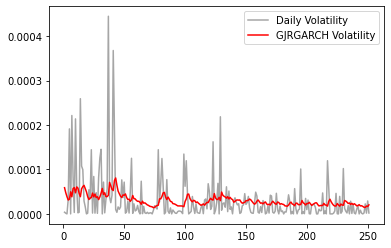

In [32]:
gjrgm_vol = gjrgm_result.conditional_volatility

# Plot the actual Bitcoin volatility
plt.plot(returns.sub(returns.mean()).pow(2), 
         color = 'grey', alpha = 0.7, label = 'Daily Volatility')

# Plot EGARCH  estimated volatility
plt.plot(gjrgm_vol**2, color = 'red', label = 'GJRGARCH Volatility')

plt.legend(loc = 'upper right')
plt.show()

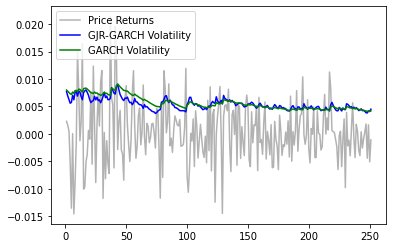

In [33]:


# Plot the actual Bitcoin returns
plt.plot(returns, color = 'grey', alpha = 0.6, label = 'Price Returns')

# Plot GJR-GARCH estimated volatility
plt.plot(gjrgm_vol, color = 'blue', label = 'GJR-GARCH Volatility')



# Plot GARCH#(1,1)  estimated volatility
plt.plot(gm_vol, color = 'green', label = 'GARCH Volatility')
plt.legend(loc = 'upper left')
plt.show()

In [34]:
gjrgm_vol = gjrgm_result.conditional_volatility
from sklearn.metrics import mean_absolute_error, mean_squared_error
#gm_vol = gm_result.conditional_volatility
def evaluate(observation, forecast): 
    # Call sklearn function to calculate MAE
    mae = mean_absolute_error(observation, forecast)
    print(f'Mean Absolute Error (MAE): {round(mae,3)}')
    # Call sklearn function to calculate MSE
    mse = mean_squared_error(observation, forecast)
    print(f'Mean Squared Error (MSE): {round(mse,3)}')
    return mae, mse

# Backtest model with MAE, MSE
evaluate(returns.sub(returns.mean()).pow(2), gjrgm_vol**2)

Mean Absolute Error (MAE): 0.0
Mean Squared Error (MSE): 0.0


(3.167971659529779e-05, 2.8717672949158107e-09)

In [35]:
print(f'GJR-GARCH BIC: {gjrgm_result.bic}')
print(f'GARCH BIC: {gm_result.bic}')

GJR-GARCH BIC: -1886.79434834885
GARCH BIC: -1897.4219236927192


In [36]:
# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':gm_result.params,
                             'p-value': gm_result.pvalues})

# Print out parameter stats
print(para_summary)

             parameter       p-value
mu        1.852808e-04  1.085053e-13
omega     6.226826e-07  0.000000e+00
alpha[1]  4.999999e-02  9.500364e-01
beta[1]   9.299998e-01  1.192343e-01


In [37]:
# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':gm_result.params,
                             'std-err': gm_result.std_err, 
                             't-value': gm_result.tvalues})

# Verify t-statistic by manual calculation
calculated_t = para_summary['parameter']/para_summary['std-err']

# Print parameter stats
print(para_summary)

             parameter       std-err      t-value
mu        1.852808e-04  2.493647e-05     7.430113
omega     6.226826e-07  3.167441e-10  1965.885531
alpha[1]  4.999999e-02  7.979432e-01     0.062661
beta[1]   9.299998e-01  5.969207e-01     1.557995


In [38]:
# Import the Python module
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform the Ljung-Box test
lb_test = acorr_ljungbox(gm_std_resid , lags = 250)
print(lb_test)

# Assuming lb_test is a DataFrame with columns 'lb_stat' and 'lb_pvalue'

# Access the 'lb_pvalue' column using the column name
p_values = lb_test['lb_pvalue']

# Create a DataFrame with the p-values
df31 = pd.DataFrame({'P-values': p_values}).T

        lb_stat  lb_pvalue
1      0.041533   0.838512
2      1.602938   0.448669
3      1.793179   0.616420
4      2.238709   0.691949
5      2.680240   0.749139
..          ...        ...
246  242.078019   0.558696
247  242.078494   0.576468
248  242.086696   0.593926
249  242.175871   0.609758
250  242.183593   0.626794

[250 rows x 2 columns]


In [39]:
# Print the log-likelihodd of normal GARCH
print('Log-likelihood of normal GARCH :', gm_result.loglikelihood)

Log-likelihood of normal GARCH : 959.7618677246232


In [41]:
last_obs=210
am = arch_model(returns, p = 1, q = 1, vol = 'GARCH', dist = 'normal')
res = am.fit(disp='off', last_obs=last_obs)

C:\Users\cdimopoulos\Anaconda3\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.413e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [42]:
# Obtain model estimated residuals and volatility
gm_resid = res.resid
gm_std = res.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Obtain the empirical quantiles
q = gm_std_resid.quantile([.01, .05])
print(q)
params=res.params
print(res)

0.01   -2.380047
0.05   -1.386910
dtype: float64
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                792.007
Distribution:                  Normal   AIC:                          -1576.01
Method:            Maximum Likelihood   BIC:                          -1562.63
                                        No. Observations:                  210
Date:                Tue, Aug 29 2023   Df Residuals:                      209
Time:                        11:05:35   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu       

In [43]:
print(res.params)
params=res.params
#Set the forecast start index t
forecast_start_index = 211

# Forecast
forecasts = res.forecast(start=forecast_start_index)

# Get conditional mean and variance from index 114 onwards
cond_mean = forecasts.mean.iloc[forecast_start_index:]
cond_var = forecasts.variance.iloc[forecast_start_index:]

# Calculate quantiles
# Calculate quantiles
quantiles = am.distribution.ppf([0.01, 0.05])
print(quantiles)



mu          3.215271e-04
omega       6.826658e-07
alpha[1]    4.999999e-02
beta[1]     9.299999e-01
Name: params, dtype: float64
[-2.32634787 -1.64485363]


C:\Users\cdimopoulos\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [45]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * quantiles[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=['1%', '5%'], index=cond_var.index)
value_at_risk.describe()

,1%,5%
count,40.000000,40.000000
mean,0.010477,0.007313
std,0.000581,0.000411
min,0.009505,0.006626
25%,0.010029,0.006997
50%,0.010513,0.007339
75%,0.010910,0.007620
max,0.011675,0.008160


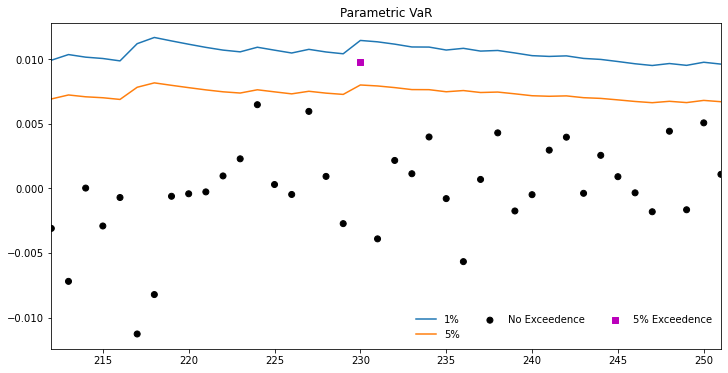

In [46]:
ax = value_at_risk.plot(legend=False, figsize=(12,6))
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])


start_index = 211
rets_2022 = returns.iloc[start_index:]
rets_2022.name = 'Portfolio Return'
c = []
for idx in value_at_risk.index:
    if rets_2022[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets_2022[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
        
c = np.array(c, dtype='object')

labels = {
    
    '#BB0000': '1% Exceedence',
    '#BB00BB': '5% Exceedence',
    '#000000': 'No Exceedence'
}

markers = {'#BB0000': 'x', '#BB00BB': 's', '#000000': 'o'}

for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2022.index[sel],
        -rets_2022.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color])
    
ax.set_title('Parametric VaR')
ax.legend(frameon=False, ncol=3)

plt.show()


In [47]:
# Obtain model estimated residuals and volatility
gm_resid = res.resid
gm_std = res.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Obtain the empirical quantiles
q22 = gm_std_resid.quantile([.01, .05])
print(q22)

0.01   -2.380047
0.05   -1.386910
dtype: float64


In [48]:
value_at_risk11 = -cond_mean.values - np.sqrt(cond_var).values * q.values[None, :]
value_at_risk11 = pd.DataFrame(value_at_risk11, columns=['1%', '5%'], index=cond_var.index)
value_at_risk11.describe()

,1%,5%
count,40.000000,40.000000
mean,0.010726,0.006116
std,0.000595,0.000347
min,0.009732,0.005537
25%,0.010268,0.005849
50%,0.010763,0.006138
75%,0.011170,0.006375
max,0.011951,0.006830


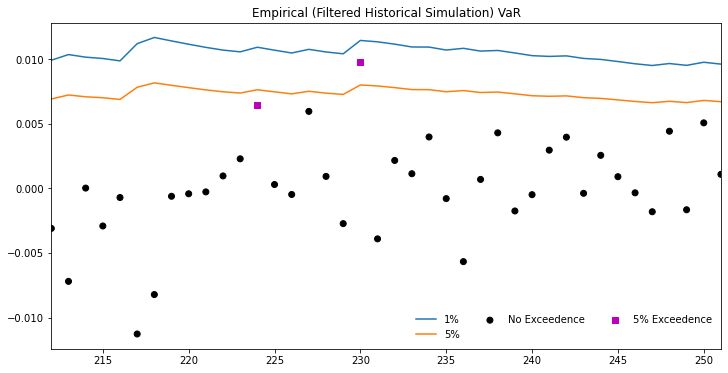

In [50]:
ax = value_at_risk.plot(legend=False, figsize=(12,6))
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])


start_index = 211
rets_2023 = returns.iloc[start_index:]
rets_2023.name = 'Portfolio Return'
c = []

c = []
for idx in value_at_risk.index:
    if rets_2023[idx] > -value_at_risk11.loc[idx, '5%']:
        c.append('#000000')
    elif rets_2023[idx] < -value_at_risk11.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
        
c = np.array(c, dtype='object')

labels = {
    
    '#BB0000': '1% Exceedence',
    '#BB00BB': '5% Exceedence',
    '#000000': 'No Exceedence'
}

markers = {'#BB0000': 'x', '#BB00BB': 's', '#000000': 'o'}

for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2023.index[sel],
        -rets_2023.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color])
    
ax.set_title('Empirical (Filtered Historical Simulation) VaR')
ax.legend(frameon=False, ncol=3)

plt.show()